European call option price: 2.6026


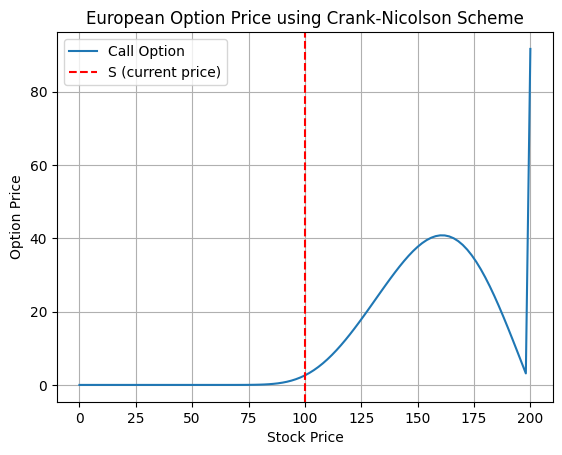

In [6]:
# !pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

def crank_nicolson_european_option(S, K, T, r, sigma, option_type='call', M=100, N=100):
    """
    Implements the Crank-Nicolson scheme to price European options.

    Parameters:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (in years)
        r (float): Risk-free interest rate
        sigma (float): Volatility of the stock
        option_type (str): 'call' or 'put'
        M (int): Number of time steps
        N (int): Number of price steps

    Returns:
        numpy.ndarray: Option prices at each stock price
        numpy.ndarray: Stock price grid
    """
    # Grid and parameters
    S_max = 2 * S  # Maximum stock price to consider
    
    # S_max = S * np.exp((r - (sigma**2)/2) * T + 3 * sigma * np.sqrt(T))
    # S_min = S * np.exp((r - (sigma**2)/2) * T - 3 * sigma * np.sqrt(T))
    
    dt = T / M
    dS = S_max / N

    grid = np.zeros((M + 1, N + 1))
    stock_prices = np.linspace(0, S_max, N + 1)

    # Boundary conditions
    if option_type == 'call':
        grid[-1, :] = np.maximum(stock_prices - K, 0)  # Final condition
        grid[:, 0] = 0  # When stock price is 0
        grid[:, -1] = S_max - K * np.exp(-r * (T - np.linspace(0, T, M + 1)))  # When stock price is very high
    elif option_type == 'put':
        grid[-1, :] = np.maximum(K - stock_prices, 0)
        grid[:, 0] = K * np.exp(-r * (T - np.linspace(0, T, M + 1)))  # When stock price is 0
        grid[:, -1] = 0  # When stock price is very high
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Coefficients
    alpha = 0.25 * dt * (sigma ** 2 * np.arange(N + 1) ** 2 - r * np.arange(N + 1))
    beta = -0.5 * dt * (sigma ** 2 * np.arange(N + 1) ** 2 + r)
    gamma = 0.25 * dt * (sigma ** 2 * np.arange(N + 1) ** 2 + r * np.arange(N + 1))

    # Matrices A and B
    A = np.zeros((N - 1, N - 1))
    B = np.zeros((N - 1, N - 1))

    for i in range(1, N):
        if i > 1:
            A[i - 1, i - 2] = -alpha[i]
            B[i - 1, i - 2] = alpha[i]
        A[i - 1, i - 1] = 1 - beta[i]
        B[i - 1, i - 1] = 1 + beta[i]
        if i < N - 1:
            A[i - 1, i] = -gamma[i]
            B[i - 1, i] = gamma[i]

    # Time-stepping
    for t in range(M - 1, -1, -1):
        rhs = B @ grid[t + 1, 1:N]
        grid[t, 1:N] = np.linalg.solve(A, rhs)
    # print(grid[0, -1])
    return grid[0, :], stock_prices

# Test the implementation
S = 100
K = 110
T = 0.5
r = 0.03
sigma = 0.2

option_type = 'call'  # Choose between 'call' and 'put'
prices, stock_prices = crank_nicolson_european_option(S, K, T, r, sigma, option_type)

# Find the price closest to the given S
closest_idx = np.argmin(np.abs(stock_prices - S))
option_price = prices[closest_idx]

print(f"European {option_type} option price: {option_price:.4f}")

# Plot the results
plt.plot(stock_prices, prices, label=f"{option_type.capitalize()} Option")
plt.axvline(S, color='red', linestyle='--', label="S (current price)")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("European Option Price using Crank-Nicolson Scheme")
plt.legend()
plt.grid()
plt.show()
